## Este notebook consiste no treinamento dos modelos pré-treinados disponíveis no PyTorch
## Para facilitar utilizaremos a biblioteca FastAi que é para o PyTorch o que o Keras é para o TensorFlow

Primeiramente, importamos todas as dependências necessárias.

In [1]:
from fastai.vision import *
from fastai.callbacks import *
from sklearn.model_selection import StratifiedKFold

Setamos o dispositivo que rodaremos as equações matriciais de tensores.

In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print("GPU available. Training on {}.".format(torch.cuda.get_device_name()))
else:
    device = 'cpu'
    print("GPU not available. Training on CPU.")

GPU available. Training on GeForce RTX 2070.


# FastAi

No fastai, para que você encapsule tudo o que é necessário, utilizaremos um `DataBunch`. Ele une as classes originais do PyTorch: Dataset e Dataloader, além de já realizar a divisão treinamento, validação e teste. É um tudo em um. No caso atual, utilizaremos 20% para teste e dos 80% restantes, utilizaremos 20% em Cross Validation.
- `TEST_PCT`: Tamanho do set de teste.
- `SIZE`: Tamanho das imagens que serão enviadas para o modelo.
- `BS`: Tamanho do batch

In [3]:
PATH = './Faces Dataset/' + 'no-resize-color'
TEST_PCT=0.2   # 20% do dataset será para o TESTE. O TREINAMENTO e a VALIDAÇÃO serão separados por Cross Validation
SIZE=224
BS=64

# Setamos uma seed para sempre termos a mesma divisão de train/test.
np.random.seed(42)
all_data = ImageDataBunch.from_folder(path=PATH, train='.', valid_pct=TEST_PCT, size=SIZE, bs=BS, device=device).normalize(imagenet_stats)

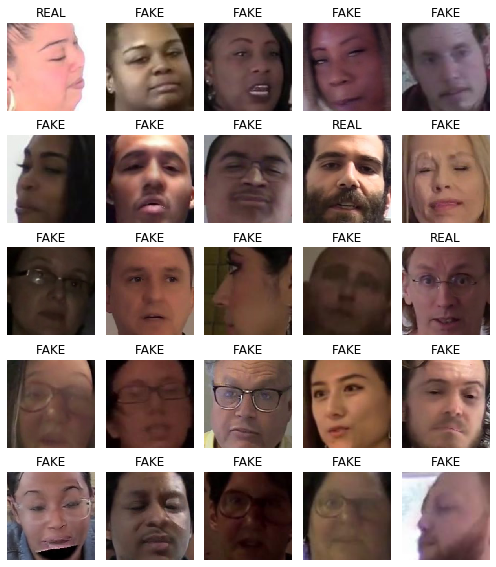

In [4]:
all_data.show_batch(figsize=(7,8))

- `data.classes`: Quais de fato são as classes do meu dataset.
- `data.c`: Quantas classes diferentes tem no meu dataset.
- `len(data.train/test_ds)`: Qual o tamanho do meu test/train set.

In [4]:
all_data.classes, all_data.c, len(all_data.train_ds), len(all_data.valid_ds)

(['FAKE', 'REAL'], 2, 2181616, 545403)

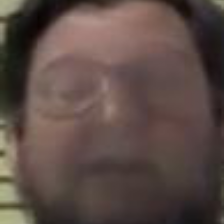

In [8]:
all_data.train_ds[0][0]

## Validação Cruzada

Pegamos os 80% dos dados que foram previamente separados para treinamento e validação e utilizamos o método `.to_df()`, que vai transformar nossos dados em um `DataFrame`, basicamente um arquivo .csv

Esse dataframe terá como coluna de treinamento `X` o Path em disco para a respectiva imagem, e terá na coluna `y` as respectivas labels "REAL" ou "FAKE" de cada imagem.

In [4]:
data_df = all_data.to_df()
data_df

,x,y
0,FAKE\aaagqkcdis.mp4_batchframe285_frameface11_...,FAKE
1,FAKE\aaagqkcdis.mp4_batchframe285_frameface13_...,FAKE
2,FAKE\aaagqkcdis.mp4_batchframe285_frameface14_...,FAKE
3,FAKE\aaagqkcdis.mp4_batchframe285_frameface15_...,FAKE
4,FAKE\aaagqkcdis.mp4_batchframe285_frameface17_...,FAKE
...,...,...
2181611,REAL\zztfqtwbah.mp4_batchframe285_frameface8_f...,REAL
2181612,REAL\zztfqtwbah.mp4_batchframe285_frameface9_f...,REAL
2181613,REAL\zztfqtwbah.mp4_batchframe300_frameface1_f...,REAL
2181614,REAL\zzuhwofwja.mp4 15.jpg,REAL


O `StratifiedKFold` do sklearn é uma variação do `KFold` regular, porém aqui ele preserva a mesma porcentagem de amostras para cada classe. Dessa forma vamos garantir que todos os folds mantenham uma divisão igualitária das classes.

- `VALID_PCT`: Trata-se da porcentagem que gostaria de se obter no Fold de **validação** do Cross Validation.
- `N_SPLITS`: Quantos folds deve-se ter para obter porcentagem `VALID_PCT` para validação. Essa parte é calculada automaticamente.

<img src="./Imagens/kf.PNG" width="800" height="1000"/>

Criaremos uma lista `data_cv` em que cada elemento conterá um `ImageList.from_df().split_by_idxs()...databunch()` indicando que dessa vez iremos utilizar um `DataFrame` para separar os itens de treinamento e validação. Os índices virão da validação cruzada. Teremos ao final a lista contendo 5 elementos.

O `random_state` vai garantir que não importa quando o programa seja executado, a divisão será sempre a mesma.

In [5]:
VALID_PCT = 0.2
N_SPLITS = int(1/VALID_PCT) # n_splits = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# data_cv aqui será nossa lista dos respectivos folds para o cross validation
data_cv = []

for train_idxs, val_idxs in skf.split(data_df['x'], data_df['y']):
    data_cv.append((ImageList.from_df(df=data_df, path=PATH)   # Criamos uma lista de imagens a partir de um dataframe.
                    .split_by_idxs(train_idx=train_idxs, valid_idx=val_idxs)   # Dividimos em treinamento e validação pelos índices do cross_validation
                    .label_from_df(cols=1)   # Cols aqui pode ser uma string com o nome da coluna ou um inteiro indicando o índice da coluna label, no caso, 1.
                    .transform(size=SIZE)   # Garantimos que o tamanho recuperado para todas as imagens seja de 224px
                    .databunch(bs=BS, device=device)))   # Transformamos em um databunch com batch_size = 64

Agora conferimos a lista `data_cv` para garantir que tudo ocorreu como o esperado.

In [6]:
for split in range(len(data_cv)):
    unique_train = np.unique(data_cv[0].train_ds.y.items, return_counts=True)
    unique_valid = np.unique(data_cv[0].valid_ds.y.items, return_counts=True)
    print(f"DataBunch {split + 1}:\n \
       Classes: {data_cv[split].classes}\n \
       Quantidade diferente de classes: {data_cv[split].c}\n \
       Porcentagem dos sets de treinamento e validação: {len(data_cv[split].train_ds) / (len(data_cv[split].train_ds) + len(data_cv[split].valid_ds))*100:.1f}% | {len(data_cv[split].valid_ds) / (len(data_cv[split].train_ds) + len(data_cv[split].valid_ds))*100:.1f}%\n \
       Quantidade de classes FAKE (treinamento): {unique_train[1][0]:,} ({unique_train[1][0] / unique_train[1].sum() * 100:.2f}%)\n \
       Quantidade de Classes REAL (treinamento): {unique_train[1][1]:,} ({unique_train[1][1] / unique_train[1].sum() * 100:.2f}%)\n \
       Quantidade de classes FAKE (validação): {unique_valid[1][0]:,} ({unique_valid[1][0] / unique_valid[1].sum() * 100:.2f}%)\n \
       Quantidade de Classes REAL (validação): {unique_valid[1][1]:,} ({unique_valid[1][1] / unique_valid[1].sum() * 100:.2f}%)\n \
---------------------------------------------"
         )

DataBunch 1:
        Classes: ['FAKE', 'REAL']
        Quantidade diferente de classes: 2
        Porcentagem dos sets de treinamento e validação: 80.0% | 20.0%
        Quantidade de classes FAKE (treinamento): 1,459,016 (83.60%)
        Quantidade de Classes REAL (treinamento): 286,276 (16.40%)
        Quantidade de classes FAKE (validação): 364,754 (83.60%)
        Quantidade de Classes REAL (validação): 71,570 (16.40%)
 ---------------------------------------------
DataBunch 2:
        Classes: ['FAKE', 'REAL']
        Quantidade diferente de classes: 2
        Porcentagem dos sets de treinamento e validação: 80.0% | 20.0%
        Quantidade de classes FAKE (treinamento): 1,459,016 (83.60%)
        Quantidade de Classes REAL (treinamento): 286,276 (16.40%)
        Quantidade de classes FAKE (validação): 364,754 (83.60%)
        Quantidade de Classes REAL (validação): 71,570 (16.40%)
 ---------------------------------------------
DataBunch 3:
        Classes: ['FAKE', 'REAL']
       

### Métricas para o treinamento

Quais métricas utilizar para garantir que nosso modelo esteja indo bem?

Antes de tudo, é necessário perceber que nosso dataset contém aproximadamente 5 vezes mais classes "FAKE" do que "REAL". Um modelo que no final apenas chute que toda e qualquer imagem é "FAKE" irá garantir uma acurácia em torno de 83%, o que é bom, mas não está entregando a história completa. Logo, sabemos que a acurácia não é interessante de ser monitorada sozinha e que o baseline mínimo para ela é de 83%. Para isso, podemos fazer uso da métrica Matthews Correlation Coefficient.

Fonte: https://en.wikipedia.org/wiki/Matthews_correlation_coefficient -> O interessante é que é explicado também o motivo de essa ser uma métrica mais vantajosa do que o F1-score.

A métrica é definida como:

$$MCC=\frac{TP \times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$

onde:
- TP = True Positive
- TN = True Negative
- FP = False Positive
- FN = False Negative

O valor retornado sempre estará na faixa de `-1` até `+1`, onde:
- `+1`: Representa uma predição perfeita.
- `0`: Representa um chute nada mais que aleatório.
- `-1`: Representa uma discordância total entre as predições e as observações.

Logo, monitoramos nosso métrica `mcc` e tentamos maximizar seu valor.

# Criando a Rede: Resnet18

Vamos começar com uma resnet18. Usarei essa arquitetura como base para detalhar o treinamento. As próximas arquiteturas seguirão o mesmo procedimento de forma mais direta.

Criamos nosso `learner` que é de fato a rede neural. Colocaremos as métricas de acurácia e `mcc`. O backbone dela será a `resnet18`.

Utilizaremos também o callback `.to_fp16()` no nosso `learner` e isso permitirá nosso modelo treinar em `MixedPrecision`, permitindo tirar vantagem dos **Tensor Cores** das placas mais recentes da NVIDIA. A utilização de `MixedPrecision` traz consigo diversas vantegens, a principal delas sendo aumento de velocidade no treinamento sem perda de acurácia comparada ao treinamento em full precision, além de ocupar menos memória na GPU. Documentação da NVIDIA explicando em detalhes: https://docs.nvidia.com/deeplearning/performance/mixed-precision-training/index.html

Vamos adicionar um callback no nosso learner que basicamente irá parar o treinamento caso a métrica `mcc` não melhores durante duas épocas por um fator mínimo `min_delta=0.01`.

Os dados que nosso `learner` recebe serão os diferentes splits do Cross Validation.

In [7]:
mcc = MatthewsCorreff()

In [8]:
split = 0

learn = cnn_learner(data=data_cv[split], 
                    base_arch=models.resnet18, 
                    metrics=[accuracy, mcc], 
                    callback_fns=[partial(EarlyStoppingCallback, monitor='matthews_correff', min_delta=0.01, patience=3)]).to_fp16()

### Dataset desbalanceado

Como observamos anteriormente, nosso dataset está desbalanceado pela alta presença de DeepFakes no dataset de treinamento. Existem várias formas de lidar com isso. Uma delas é simplesmente apagar grande parte das imagens FAKE, mas se fizermos isso nós podemos perder informação valiosa. Outra forma de lidar com isso é garantir que a rede seja penalizada com mais força caso erre uma classe REAL. Para fazer isso, recorremos à nossa função de custo, a `CrossEntropyLoss`. Podemos mudar essa função no nosso `learner` passando pesos para as classes, que por padrão possuem peso `1.0`. Para calcular o peso das classes, uma forma comum feita é `weight_label_i = max(nr_samples_per_label) / nr_samples_label_i`. Ou seja, pegamos o número de amostras da classe mais populosa e dividimos pelo número de amostras da classe `i`. Observamos que para a classe mais populosa do dataset o peso continuará sendo `1.0`, mas no caso da mais em falta o peso irá ser maior de uma forma proporcional. Por questões empíricas de estabilidade, vamos dividir o resultado da classe REAL por 2.

In [24]:
# Pegamos a quantidade de amostras por classe
unique_train = np.unique(data_cv[split].train_ds.y.items, return_counts=True)[1]

# Fake Weight
fake_weight = unique_train.max() / unique_train[0]
# Real Weight
real_weight = unique_train.max() / unique_train[1] / 2

weight = torch.tensor([fake_weight, real_weight])
weight

tensor([1.0000, 2.5483])

Feita a correta alteração podemos agora substituir a função de custo do nosso learner.

In [25]:
learn.loss_func = nn.CrossEntropyLoss(weight=weight).to(device)
learn.loss_func

CrossEntropyLoss()

Perfeito.

# Treinamento
# Fold 1

Utilizamos a função `lr_find()` para encontrar uma região otimizada para o nosso `learning_rate`. Basicamente o que buscamos é uma região com elevado declive e que no momento seja um learning rate razoavelmente alto. Essa região nos indica a fração que devemos utilizar para o `learning_rate`. Essa forma de encontrar um `learning_rate` vem do trabalho de *Leslie n. Smith*: 

#### *Cyclical Learning Rates for Training Neural Networks*: https://arxiv.org/pdf/1506.01186.pdf

epoch,train_loss,valid_loss,accuracy,matthews_correff,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-05
Min loss divided by 10: 2.75E-07


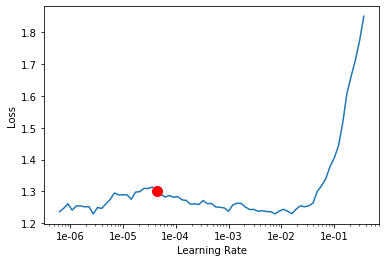

In [24]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

Treinamos então a rede por 3 épocas utilizando a política One Cycle, de *Leslie N. Smith*

#### *Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates*: https://arxiv.org/pdf/1708.07120.pdf

Também adicionaremos um callback que irá salvar o modelo cuja época teve o melhor resultado para `mcc`

In [11]:
learn.fit_one_cycle(10, 
                    max_lr=slice(3e-5, 3e-3), 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='matthews_correff', name='resnet18_best_mcc_freezed_fold1')])

epoch,train_loss,valid_loss,accuracy,matthews_correff,time
0,0.411210,0.293634,0.886894,0.588989,1:01:26
1,0.343241,0.250459,0.902391,0.663818,1:01:36
2,0.296755,0.223911,0.908071,0.699985,1:02:15
3,0.262222,0.182785,0.925807,0.739961,1:02:47
4,0.242290,0.175009,0.930547,0.754910,1:01:50
5,0.248263,0.153335,0.940686,0.782253,1:03:00
6,0.224310,0.151694,0.939637,0.788289,1:01:42
7,0.210096,0.145546,0.942788,0.798547,1:04:15
8,0.212681,0.149419,0.939025,0.794806,1:03:24
9,0.192255,0.141869,0.942366,0.802821,1:03:55


Better model found at epoch 0 with matthews_correff value: 0.5889890193939209.
Better model found at epoch 1 with matthews_correff value: 0.6638181805610657.
Better model found at epoch 2 with matthews_correff value: 0.6999846696853638.
Better model found at epoch 3 with matthews_correff value: 0.739960789680481.
Better model found at epoch 4 with matthews_correff value: 0.7549095153808594.
Better model found at epoch 5 with matthews_correff value: 0.7822526693344116.
Better model found at epoch 6 with matthews_correff value: 0.7882886528968811.
Better model found at epoch 7 with matthews_correff value: 0.7985469102859497.
Better model found at epoch 9 with matthews_correff value: 0.802821159362793.


### Interpreter

Criamos um interpretador para nossa CNN treinada.

In [12]:
interp = ClassificationInterpretation.from_learner(learn)

Criamos uma matriz de confusão para checar os resultados. Lembrando que o modelo está congelado.

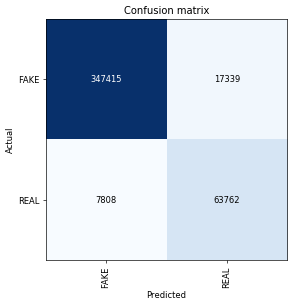

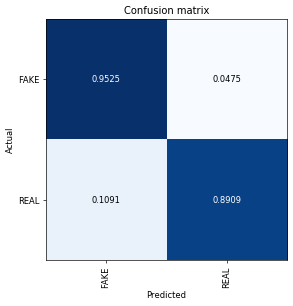

In [13]:
interp.plot_confusion_matrix(normalize=False, figsize=(5,5), dpi=60)
interp.plot_confusion_matrix(normalize=True, norm_dec=4, figsize=(5,5), dpi=60)

Vamos observar algumas imagens que obtiveram as maiores top_losses

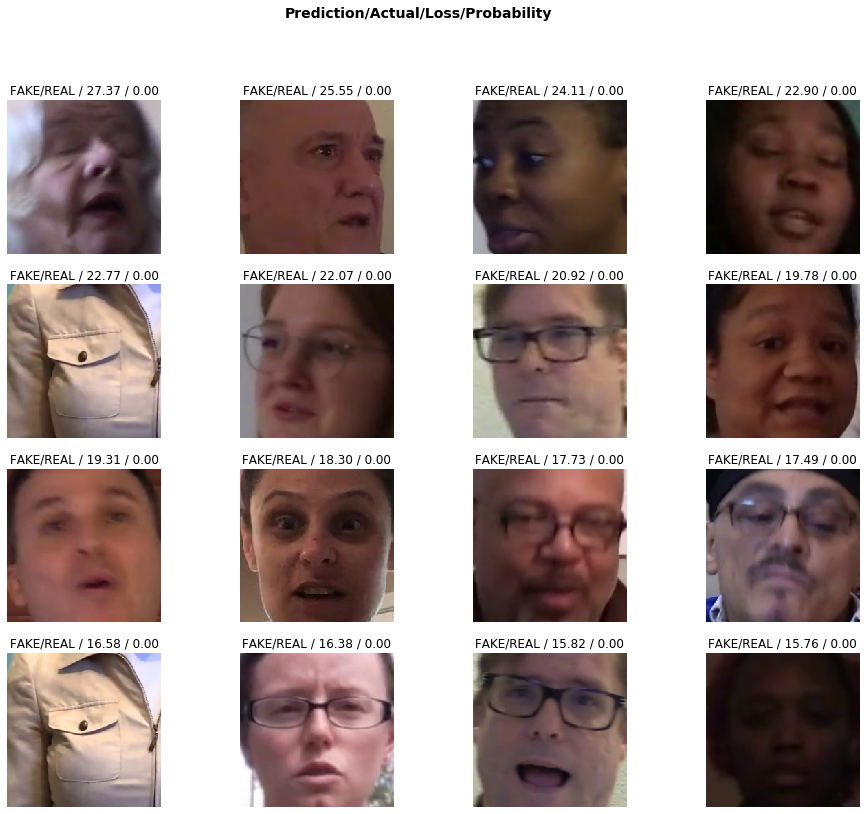

In [14]:
interp.plot_top_losses(16, figsize=(16,13))

Como podemos observar, os top_losses da rede, na maioria, giram em torno de predizer um rosto REAL como FAKE, logo, os top losses da rede estão para o lado dos Falsos Positivos.

No mais, agora que estamos com uma acurácia de 95.5% e um mcc de 0.847, vamos descongelar a rede e treinar mais 3 épocas.

# Treinamento - Descongelada

In [26]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,matthews_correff,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.10E-07


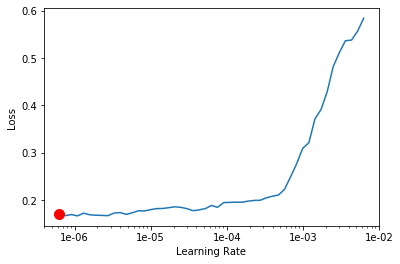

In [16]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [17]:
learn.fit_one_cycle(10, 
                    max_lr=slice(3e-7, 3e-5), 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='matthews_correff', name='resnet18_best_mcc_unfreezed_fold1')])

epoch,train_loss,valid_loss,accuracy,matthews_correff,time
0,0.201169,0.134888,0.945946,0.812625,1:18:10
1,0.181927,0.129848,0.946588,0.818440,1:17:35
2,0.142109,0.110047,0.955815,0.844275,1:20:04
3,0.141337,0.103694,0.957289,0.851161,1:19:00
4,0.116282,0.094747,0.961295,0.863058,1:16:59
5,0.127656,0.094152,0.960878,0.863188,1:16:45
6,0.123535,0.092838,0.961086,0.864480,1:15:55


Better model found at epoch 0 with matthews_correff value: 0.8126245141029358.
Better model found at epoch 1 with matthews_correff value: 0.8184401392936707.
Better model found at epoch 2 with matthews_correff value: 0.8442749977111816.
Better model found at epoch 3 with matthews_correff value: 0.8511608242988586.
Better model found at epoch 4 with matthews_correff value: 0.8630580306053162.
Better model found at epoch 5 with matthews_correff value: 0.8631877899169922.
Better model found at epoch 6 with matthews_correff value: 0.8644796013832092.
Epoch 7: early stopping
Better model found at epoch 7 with matthews_correff value: 0.8683467507362366.


In [27]:
learn.fit_one_cycle(5, 
                    max_lr=slice(6e-7, 6e-5), 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='matthews_correff', name='resnet18_best_mcc_unfreezed_fold1')])

epoch,train_loss,valid_loss,accuracy,matthews_correff,time
0,0.092343,0.088136,0.962727,0.869403,1:17:04
1,0.090844,0.083182,0.965324,0.876847,1:17:48
2,0.092304,0.083646,0.965296,0.878041,1:21:42
3,0.078012,0.077932,0.968285,0.886600,1:22:28
4,0.071917,0.083671,0.965624,0.879738,1:17:56


Better model found at epoch 0 with matthews_correff value: 0.8694032430648804.
Better model found at epoch 1 with matthews_correff value: 0.8768472671508789.
Better model found at epoch 2 with matthews_correff value: 0.8780410289764404.
Better model found at epoch 3 with matthews_correff value: 0.8865997195243835.


Novamente criamos um interpretador para nossa CNN agora descongelada.

In [28]:
interp_unf = ClassificationInterpretation.from_learner(learn)

Criamos uma matriz de confusão para checar os resultados com o modelo descongelado.

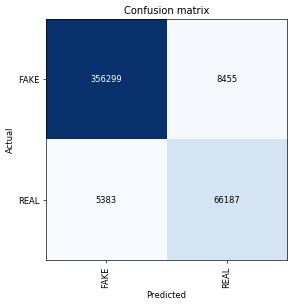

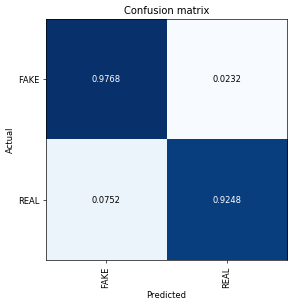

In [29]:
interp_unf.plot_confusion_matrix(normalize=False, figsize=(5,5), dpi=60)
interp_unf.plot_confusion_matrix(normalize=True, norm_dec=4, figsize=(5,5), dpi=60)

# Treinamento
# Fold 2